# Opinion Shaping in Social Networks Using Reinforcement Learning

## Libs

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import time

## Graph Creation

```Some text to explain what we are doing```

### Tests

### Simulation of the doc graph

In [3]:
import networkx as nx
import random

# Create a directed graph
G = nx.DiGraph()

# Add 20 nodes to the graph
G.add_nodes_from(range(1, 21))

# Generate random weights for directed edges such that the sum of weights going to a node is 1
for i in range(1, 21):
    # Generate random weights for edges going to the current node
    weights = [random.uniform(0, 1) for _ in range(1, 21-i)]

    # Normalize the weights to ensure the sum is equal to 1
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    # Add edges with weights to the graph
    for j,


SyntaxError: invalid syntax (1545117493.py, line 20)

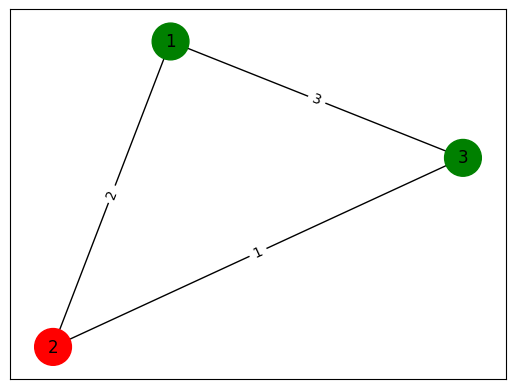

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add nodes with status attribute
G.add_node(1, status='active')
G.add_nodes_from([(2, {'status': 'inactive'}), (3, {'status': 'active'})])

# Add weighted edges
G.add_edge(1, 2, weight=2)
G.add_edges_from([(1, 3, {'weight': 3}), (2, 3, {'weight': 1})])

# Extract node statuses and edge weights
node_statuses = nx.get_node_attributes(G, 'status')
edge_weights = nx.get_edge_attributes(G, 'weight')

# Draw nodes with color based on status
node_colors = ['green' if status == 'active' else 'red' for status in node_statuses.values()]

# Draw the graph with edge labels and customizations
pos = nx.spring_layout(G)  # You can change the layout algorithm as needed
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Display the plot
plt.show()


In [5]:
import networkx as nx
import random
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add 20 nodes with status and color
for i in range(1, 11):
    status = random.choice([0, 1, 2])
    color = 'red' if status == 0 else 'green' if status == 1 else 'blue'
    G.add_node(i, status=status, color=color)

# Randomly assign weights to the edges such that the sum of weights going to each node is 1
for node in G.nodes():
    # Generate random weights for outgoing edges
    outgoing_weights = [random.uniform(0.01, 1) for _ in range(random.randint(1, 5))]

    # Remove the possibility of self-loops
    #the ondition that i addes
    possible_targets = set(G.nodes()) - {node}

    # Normalize weights to ensure the sum is 1
    total_weight = sum(outgoing_weights)
    normalized_weights = [weight / total_weight for weight in outgoing_weights]

    # Add edges with weights
    for target, weight in zip(random.sample(possible_targets, len(outgoing_weights)), normalized_weights):
        G.add_edge(node, target, weight=weight)

# Draw the graph with a larger plot, smaller nodes, and a more organized layout
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for consistent layout
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, font_color='white', font_size=8, edge_color='gray', width=1, alpha=0.7)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Display the plot
plt.show()


TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [6]:
adjacency_matrix = nx.adjacency_matrix(G).toarray()

# Print the adjacency matrix
print("Adjacency Matrix:")
print(adjacency_matrix)

Adjacency Matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a directed graph
G = nx.DiGraph()

# Add 20 nodes with status and color
for i in range(1, 11):
    status = random.choice([0, 1, 2])
    color = 'red' if status == 0 else 'green' if status == 1 else 'blue'
    G.add_node(i, status=status, color=color)

# Randomly assign weights to the edges such that the sum of weights going to each node is 1
for node in G.nodes():
    # Generate random weights for outgoing edges
    outgoing_weights = [random.uniform(0.01, 1) for _ in range(random.randint(1, 5))]

    # Remove the possibility of self-loops
    possible_targets = set(G.nodes()) - {node}

    # Normalize weights to ensure the sum is 1
    total_weight = sum(outgoing_weights)
    normalized_weights = [weight / total_weight for weight in outgoing_weights]

    # Add edges with weights
    for target, weight in zip(random.sample(possible_targets, len(outgoing_weights)), normalized_weights):
        G.add_edge(node, target, weight=weight)

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for consistent layout
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, font_color='white', font_size=8, edge_color='gray', width=1, alpha=0.7)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Animation update function
def update(frame):
    # Modify the graph attributes here based on your evolution logic
    # For example, you can update node status, edge weights, etc.
    # Make sure to clear the previous plot before redrawing the updated graph
    ax.clear()

    # Update the graph attributes

    # Redraw the graph with the updated attributes
    nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, font_color='white', font_size=8, edge_color='gray', width=1, alpha=0.7)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Set the number of frames (time steps) for the animation
num_frames = 10

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)

# Display the plot
plt.show()



TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

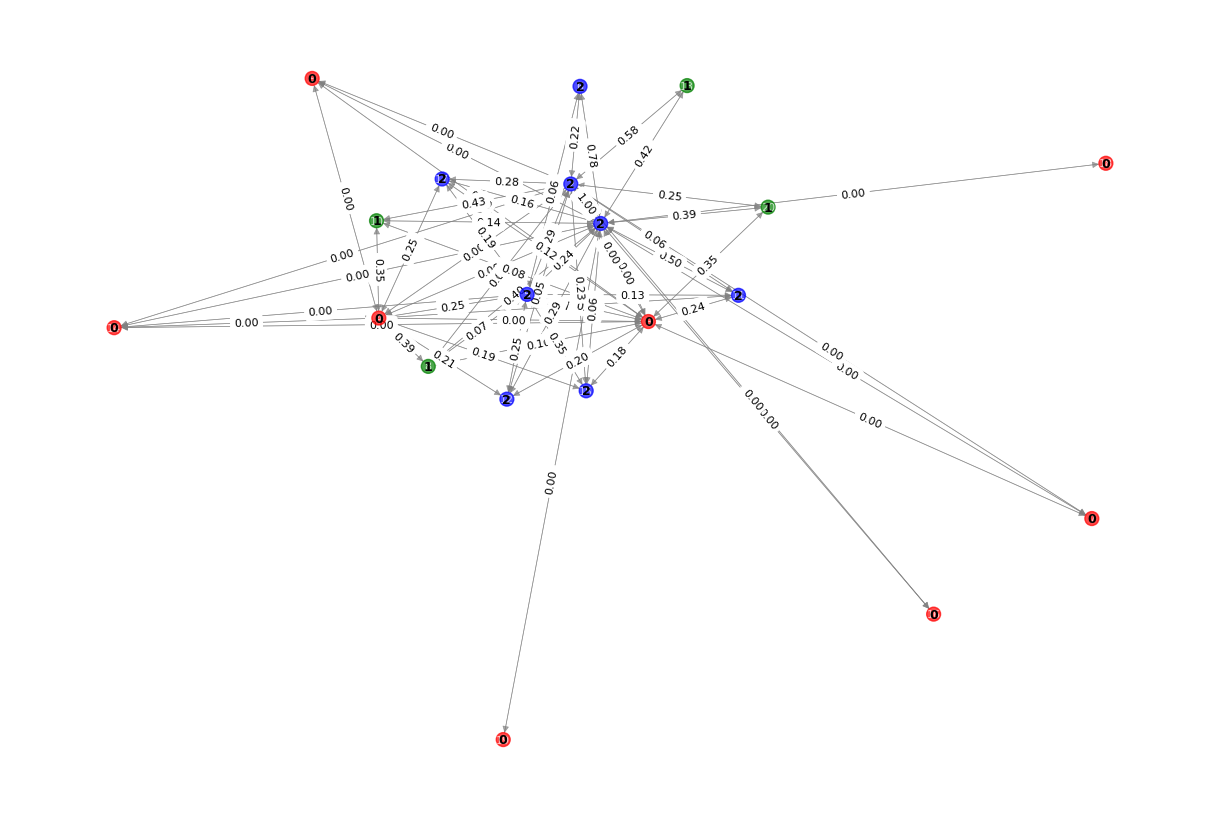

In [8]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add 20 nodes with status and color
for i in range(1, 21):
    status = random.choice([0, 1, 2])
    value = random.uniform(0, 1)
    color = 'red' if status == 0 else 'green' if status == 1 else 'blue'
    G.add_node(i, status=status, color=color, value=value)

# Randomly assign weights to the edges such that the sum of weights going to each node is 1
for node in G.nodes():
    # Generate random weights for outgoing edges
    outgoing_weights = [random.uniform(0.1, 1) for _ in range(random.randint(1, 5))]

    # Remove the possibility of self-loops
    possible_targets = set(G.nodes()) - {node}

    # If the node is red (status == 0), set outgoing weights to 0
    if G.nodes[node]['status'] == 0:
        outgoing_weights = [0] * len(outgoing_weights)

    # Normalize weights to ensure the sum is 1
    total_weight = sum(outgoing_weights)
    normalized_weights = [weight / total_weight if total_weight > 0 else 0 for weight in outgoing_weights]

    # Add edges with weights
    for target, weight in zip(possible_targets, normalized_weights):
        G.add_edge(node, target, weight=weight)
        G.add_edge(target, node, weight=weight)  # Add the corresponding reverse edge

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust the 'k' parameter for spread-out or more compact layout
group_labels = {i: G.nodes[i]['status'] for i in G.nodes()}
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_colors, font_color='white', font_size=8, edge_color='gray', width=0.5, alpha=0.7)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

nx.draw_networkx_labels(G, pos, labels=group_labels, font_size=9, font_color='black', font_weight='bold')

# Display the plot
plt.show()


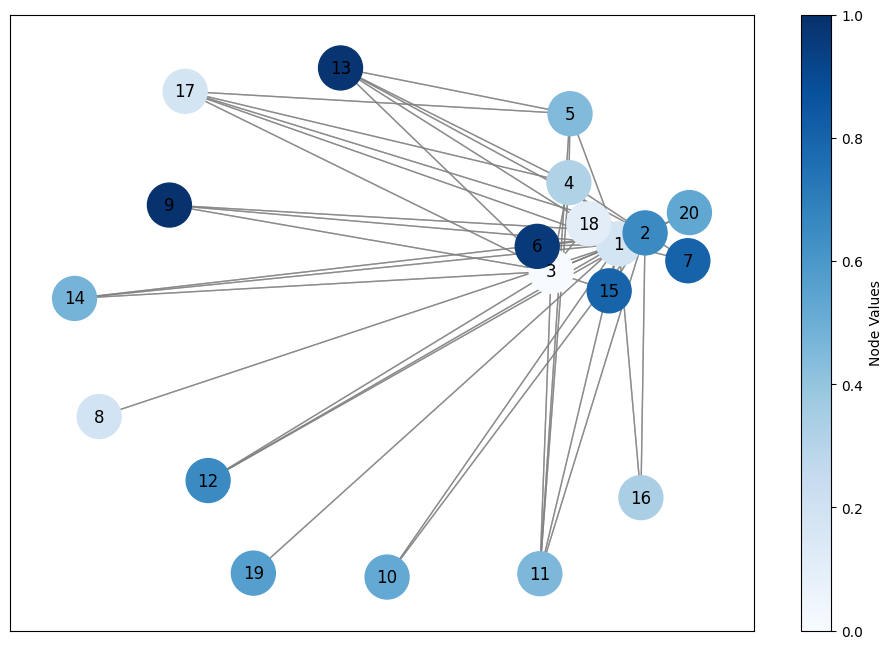

In [9]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Create a directed graph
G = nx.DiGraph()

# Add 20 nodes with status and random values
for i in range(1, 21):
    status = random.choice([0, 1, 2])
    value = random.uniform(0, 1)
    color = 'red' if status == 0 else 'green' if status == 1 else 'blue'
    G.add_node(i, status=status, color=color, value=value)

# Randomly assign weights to the edges such that the sum of weights going to each node is 1
for node in G.nodes():
    # Generate random weights for outgoing edges
    outgoing_weights = [random.uniform(0.1, 1) for _ in range(random.randint(1, 5))]

    # Remove the possibility of self-loops
    possible_targets = set(G.nodes()) - {node}

    # If the node is red (status == 0), set outgoing weights to 0
    if G.nodes[node]['status'] == 0:
        outgoing_weights = [0] * len(outgoing_weights)

    # Normalize weights to ensure the sum is 1
    total_weight = sum(outgoing_weights)
    normalized_weights = [weight / total_weight if total_weight > 0 else 0 for weight in outgoing_weights]

    # Add edges with weights
    for target, weight in zip(possible_targets, normalized_weights):
        G.add_edge(node, target, weight=weight)
        G.add_edge(target, node, weight=weight)  # Add the corresponding reverse edge

# Draw the graph with spring layout
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.3)  # Adjust the 'k' parameter for spread-out or more compact layout

# Get node colors based on random values
node_colors = [G.nodes[node]['value'] for node in G.nodes()]

# Plot nodes with color scale
node_collection = nx.draw_networkx_nodes(G, pos, cmap=cm.Blues, node_color=node_colors, node_size=1000, vmin=0, vmax=1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1, alpha=0.7)

# Add a colorbar
plt.colorbar(node_collection, label='Node Values')

# Display the plot
plt.show()
